In [1]:
!pip install -qqq kymatio 

In [2]:
# Make sure those instructions run.
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

import kymatio
import torch
from kymatio.scattering2d.filter_bank import filter_bank, morlet_2d, gabor_2d
from kymatio import Scattering2D
N=64 # Size of a signal
J=4 # Scale of the Scattering Transform
L=8 # Number of angles used.

filters_set = filter_bank(N, N, J, L=L)

scattering_ord_1 = Scattering2D(J=J, shape=(N,N), max_order=1, frontend='numpy')
scattering_ord_2 = Scattering2D(J=J, shape=(N,N), frontend='numpy')


In [3]:
# Colorize a complex signal.
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c


# What is a Scattering transform?
Wavelet scattering transforms compute an affine-invariant representation of an input signal which is stable to deformations and preserves high frequency information. Mathematically principled reasoning guides the design of the scattering transform network, which can be viewed as a convolutional neural network where the filters are fixed, defined as wavelet transform operators. More specifically, the scattering transform is a cascade of convolutions with wavelet filters followed by nonlinear modulus and averaging operations. 

We propose to study the Scattering Transform of order at most 2, which is explicitely given  for a signal $x\in L^2(\mathbb{R}^d)$ by:
$$S_J[\emptyset] x =|x| \star \phi_J,$$
$$S_J[\lambda_1] x =|x\star \psi_{\lambda_1}|\star \phi_J,$$
$$S_J[\lambda_1,\lambda_2] x =||x\star \psi_{\lambda_1}|\star \psi_{\lambda_2}|\star \phi_J,$$

and $S^2_Jx=[S[\emptyset]x,S_J[\lambda_1]x,S[\lambda_1,\lambda_2]x]_{|\lambda_1|> |\lambda_2|}, S_J^1x=[S[\emptyset]x,S[\lambda_1]x]_{\lambda_1}$.

Note that here, $|\lambda_2|< |\lambda_1|$, where $\lambda=(2^{-j},\theta)$ such that we write $|\lambda|=2^{-j}$. As during the lectures, for $\lambda=(2^{-j},\theta)$,
$$\psi_{\lambda}(u)=\frac{1}{2^{2j}}\psi(\frac{r_{-\theta}u}{2^j})$$
$$\phi_J(u)=\frac{1}{2^{2J}}\phi(\frac{u}{2^J})$$
We assume that $0\leq j<J$ and $L=8$ angles so that $\theta \in \Theta=\{\frac{0\pi}{4},...,\frac{7\pi}{4}\}\subset[0,2\pi]$.  Here:
$$\phi(u)\propto e^{-\frac{\Vert u\Vert^2}{2\sigma^2}}$$
and
$$\psi(u)\propto (e^{iu^T\xi}-\beta)e^{-\frac{\Vert u\Vert^2}{2\sigma^2}}$$

$\beta$ is adjusted such that $\hat \psi(0)=0$ and typically $\sigma\approx 1$.

We will now use the package kymatio to compute a Scattering Transform. Note that in kymatio, it is possible to use a Torch or a Numpy backend.
    

1. Display the filters used. Explain the function `littlewood_paley`. __Hint:__ You can use some code from: https://www.kymat.io/gallery_2d/plot_filters.html#sphx-glr-gallery-2d-plot-filters-py

/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_17386/2087143216.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


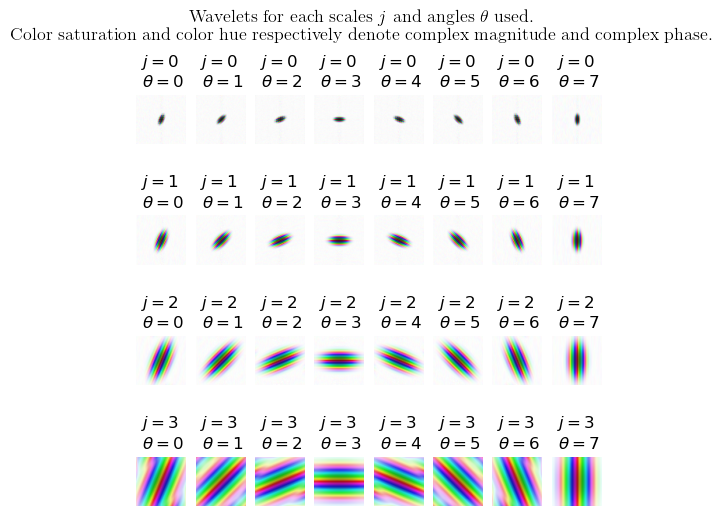

In [4]:
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt
import numpy as np
from kymatio.scattering2d.filter_bank import filter_bank
from scipy.fft import fft2
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
i = 0
for filter in filters_set['psi']:
    f = filter["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(
        "$j = {}$ \n $\\theta={}$".format(i // L, i % L))
    i = i+1

fig.suptitle((r"Wavelets for each scales $j$ and angles $\theta$ used."
              "\nColor saturation and color hue respectively denote complex "
              "magnitude and complex phase."), fontsize=13)
fig.show()

In [5]:
def littlewood_paley(S, display=True):
    wavelets = []
    gabors = []
    J=S.J
    L=S.L
    M=S.shape[0]
    N=S.shape[1]
    shape = (M,N)
    ranges = [torch.arange(-(s // 2), -(s // 2) + s, dtype=torch.float) for s in shape]
    grid = torch.stack(torch.meshgrid(*ranges), 0).numpy()
    for j in range(J):
        for theta in range(L):
            psi_signal = morlet_2d(M, N, 0.8 * 2**j,
            (int(L-L/2-1)-theta) * np.pi / L,
            3.0 / 4.0 * np.pi /2**j, 4.0/L)
            psi_signal_fourier = np.fft.fft2(psi_signal)
        # drop the imaginary part, it is zero anyway
            psi_signal_fourier = np.real(psi_signal_fourier)
            wavelets.append(psi_signal_fourier)
            gabor = gabor_2d(M, N, 0.8 * 2**j,
            (int(L-L/2-1)-theta) * np.pi / L,
            3.0 / 4.0 * np.pi /2**j, 4.0/L)
            gabor = np.fft.fft2(np.fft.ifftshift(gabor))
            gabors.append(gabor)
      
    wavelets = np.asarray(wavelets)
    gabors = np.asarray(gabors)
    lp = (np.abs(wavelets) ** 2).sum(0)
    fig, ax = plt.subplots()

    plt.imshow(np.fft.fftshift(lp))
    if display:
        grid = grid + 32#18
        for i in np.abs(gabors) ** 2:
            wave = np.fft.fftshift(i)
            ax.contour(grid[1], grid[0], wave, 1, colors='white')


/Users/oyallon/anaconda/envs/MAP670R-2022/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525474122/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


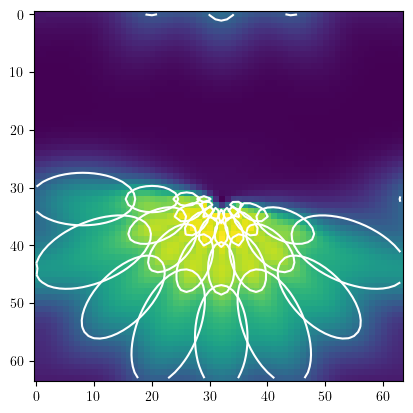

In [6]:
littlewood_paley(scattering_ord_1)

2. Explain why $\Theta \cap [\pi,2\pi]=\emptyset$.

3. If $\hat\psi(\omega)=\hat\kappa(\omega-\omega_0)$, where $\kappa(u)\propto e^{-\frac{\Vert u\Vert^2}{2\sigma^2}}$, then show that $|x\star\psi|=|x^{\omega_0}\star\kappa|$, where $\hat x^{\omega_0}(\omega)=\hat x(\omega+\omega_0)$.

__Hint:__ $\widehat{L_a x}(\omega)=\hat x(\omega) e^{-i\omega^Ta}$, $\widehat{e^{i.^Ta}x}(\omega)=\hat x(\omega-a)$, and $\mathcal{F}^{-1} (\hat x)(u)\propto \int_{\mathbb{R}^d} \hat x(\omega)e^{i\omega^Tu}\,d\omega$.

Deduce why $|\lambda_2|< |\lambda_1|$. What is the total number of Scattering coefficients for $n=0,n=1,n=2$ and some given $L, J$?

4. Compute the 2D Scattering Transform of a pure wave signal, with frequency $\omega_0>0$ given by:

$$x(u_1,u_2)=\sin(2\pi \omega_0(u_1+u_2))$$

Explain the analogy of the Scattering with a Fourier Transform.  __Hint:__ You can use the function `plot_disk_scattering`. Explain this function.  Fig 4. of https://arxiv.org/pdf/1203.1513.pdf can be helpful...

In [13]:
def plot_scattering_disk(src_img,scattering_coefficients,J,L=8):
    fig,ax = plt.subplots()
    norm = mpl.colors.Normalize(scattering_coefficients.min(), scattering_coefficients.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap="gray")
    nb_coeffs, window_rows, window_columns = scattering_coefficients.shape
    plt.imshow(1-src_img,cmap='gray',interpolation='nearest', aspect='auto')
    ax.axis('off')
    offset = 0.1
    for row in range(window_rows):
        for column in range(window_columns):
            ax=fig.add_subplot(window_rows, window_columns, 1 + column + row * window_rows, projection='polar')
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_yticklabels([])  # turn off radial tick labels (yticks)
            ax.set_xticklabels([])  # turn off degrees
            coefficients = scattering_coefficients[:, row, column]
            for j in range(J):
                for l in range(L):
                    coeff = coefficients[l + (J - 1 - j) * L]
                    color = mpl.colors.to_hex(mapper.to_rgba(coeff))
                    ax.bar(x=(4.5+l) *  np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
                    ax.bar(x=(4.5+l+L) * np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)

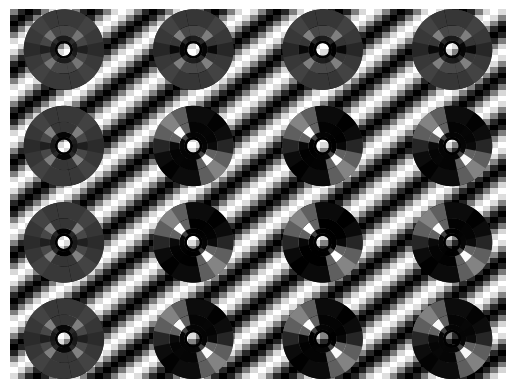

In [12]:
T=4 # Vary the period T
x=np.zeros((64,64))
for i in range(64):
    for j in range(64):
        x[i,j]=np.sin((i+j)/T*3.14)
        
S = scattering_ord_1(x)
plot_scattering_disk(x,S,4)

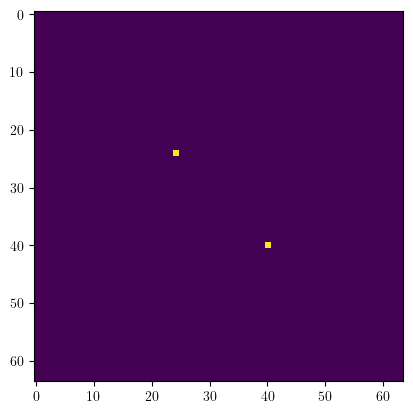

In [11]:
fftx=np.abs(np.fft.fft2(x))
plt.imshow(np.fft.fftshift(fftx))

5. Using the functions given below, verify that the Scattering Transform is stable to translation. Relate the stability to the parameter $J$. What about rotations? Why?

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from kymatio.torch import Scattering2D
device='cpu'

S_1 = Scattering2D(J=1, shape=(28, 28), max_order=2, backend='torch').to(device)
S_2 = Scattering2D(J=2, shape=(28, 28), max_order=2, backend='torch').to(device)
S_3 = Scattering2D(J=3, shape=(28, 28), max_order=2, backend='torch').to(device)
S_4 = Scattering2D(J=4, shape=(28, 28), max_order=2, backend='torch').to(device)

In [ ]:
def get_rotation(dfl, num_data=1):
    dfl = torch.deg2rad(dfl)
    rotate_1 = torch.stack([torch.cos(dfl), torch.sin(dfl), torch.zeros(dfl.shape)], dim=1)
    rotate_2 = torch.stack([-torch.sin(dfl), torch.cos(dfl), torch.zeros(dfl.shape)], dim=1)
    rotation = torch.stack([rotate_1, rotate_2], dim=1)
    return rotation

def get_translation(dfl, num_data=1):
    dfl = 2*dfl/28

    ones = torch.ones(dfl.shape)
    zeros = torch.zeros(dfl.shape)
    translate_1 = torch.stack([ones, zeros, -dfl], dim=1)
    translate_2 = torch.stack([zeros, ones, zeros], dim=1)
    translate = torch.stack([translate_1, translate_2], dim=1)
    return translate

def get_identity(dfl):
    return torch.tensor([[[1.0, 0, 0],[0, 1.0, 0]]]*dfl.shape[0])
def generate_transform(dfl, transform, img):
    dfl = torch.tensor([dfl])
    transformed_grid = F.affine_grid(transform(dfl), img.shape)
    return transformed_grid
 
def visualize_distances(norm, arang, num_transformations = 1, name="shear", models=None, markers=None):
    """ Creates figures for each transformation
        The x axis of each figure is the transformation levels
        The y axis of each figure is the distance between scattering representations 
        of the original image and the transformed image
        
        Parameters:
            model_values-- dictionnary taht contains all the parameters used in the experiments
            num_transformations -- the number of tranformations which is equal tot he number of figures
        Returns:
            figures -- list of figures
    """
    plt.rcParams.update({'font.size': 10})
    colors = ['#FFA500', '#006400', '#ff0000','#0000ff']
    markers = ['o',  "o", "o", "o"]
    figures = []
    for idx in range(num_transformations):
        f = plt.figure(figsize=(10,10)) # create plots
        for c in range(0, len(norm)):
            plt.rc('xtick', labelsize=14)
            plt.rc('ytick', labelsize=14)
            plt.scatter(x=arang, y= norm[c], 
                        label= '{}'.format(models[c]),
                        color =colors[c], 
                        marker=markers[c])
            plt.xlabel("Strength", fontsize=16)
            plt.title(name.capitalize(),    fontsize=16)
            plt.ylabel('Normalized Distance',   fontsize=16)
            plt.legend(fontsize = 20)
        ax=plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=15)
        plt.savefig("{}.pdf".format(name))
        figures.append(f)
    return figures

def generate_transforms(ranges, name="translation"):
    if name == "translation":
        transforms = get_translation(ranges, num_data=len(ranges))
    elif name == "rotation":
        transforms = get_rotation(ranges, num_data=len(ranges))
    aff = F.affine_grid(transforms, example_data.expand(transforms.shape[0], 1, 28, 28).shape)
    transformed_img = F.grid_sample(example_data.expand(transforms.shape[0], 1, 28, 28), aff, mode='nearest', align_corners=False)
    transforms_id = get_identity(ranges)
    aff_id = F.affine_grid(transforms_id, example_data.expand(transforms_id.shape[0], 1, 28, 28).shape)
    transformed_0 = F.grid_sample(example_data.expand(transforms_id.shape[0], 1, 28, 28), aff_id, mode='nearest', align_corners=False)
    transformed_grid = -aff + aff_id 
    return transformed_img, transformed_0, transformed_grid
 
def generate_distances(S, transformed_0, transformed_img):
    S.to(device)
    rep_0 = S(transformed_0)
    rep = S(transformed_img)
    bs = rep_0.shape[0]
    norm_num = torch.linalg.norm(rep_0.reshape(bs, -1) - rep.reshape(bs, -1), dim=-1)
    norm_denom = torch.linalg.norm(transformed_0.reshape(bs, -1), dim=-1).to(device)
    norm_denom[norm_denom == 0.0] = 1
    return norm_num/norm_denom   


In [ ]:
img_name = os.path.join(os.getcwd(), "digit.jpg")
src_img = Image.open(img_name).convert('L').resize((28,28))
example_data = torch.from_numpy(np.array(src_img)).float()
config_1 = (torch.arange(0, 20, .5), "translation")
config_2 = (torch.arange(0, 180, .5), "rotation")
configs = [config_1, config_2]

6. In this question, we propose to reconstruct an image from its Scattering coefficients. To this, we propose to solve via Gradient Descent, for an input image $x_0$:
$$\inf_x \Vert S^n_Jx-S^n_Jx_0\Vert^2$$

Here, we will use torch with Adam optimizer and $x_0$ will be obtained from a random initialization. Compare the results for various values of $J$ and for $n=0,1,2$. Comment.

__Hint:__ You can take inspiration from the code here: https://www.kymat.io/gallery_2d/plot_invert_scattering_torch.html

7. Is a (2D) Scattering Transform a diffeomorphism?

8. Implement a Scattering Classification pipeline using 100 training samples from CIFAR-10. The training Scattering coefficients are fed into a Linear Layer or a Multi Layer Perceptron trained via SGD.